Repo card metadata block was not found. Setting CardData to empty.


Columns: ['task_type', 'dataset', 'input', 'output', 'situation', 'label', 'extra', 'instruction']
Train shape: (7446, 8)
Expanded shape: (18276, 3)
                                            sentence         aspect  polarity
0  [It might be the best sit down food I've had i...           food  positive
1  [It might be the best sit down food I've had i...          place   neutral
2  [Hostess was extremely accommodating when we a...          staff  positive
3  [Hostess was extremely accommodating when we a...  miscellaneous   neutral
4  [We were a couple of minutes late for our rese...  miscellaneous   neutral


/var/folders/by/cnzpgkq568d37lzdkvmc0vsc0000gn/T/ipykernel_14116/1495461135.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=expanded["polarity"], palette="viridis")


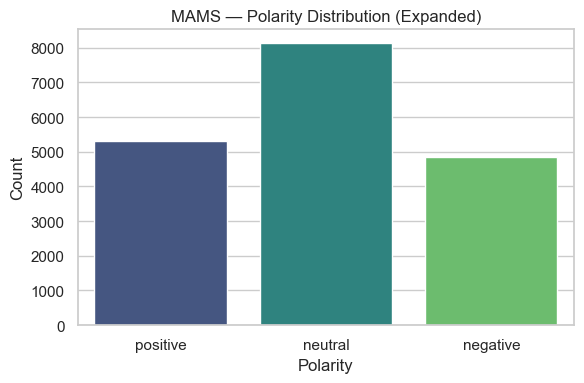


=== Polarity Counts ===
polarity
neutral     8119
positive    5309
negative    4848
Name: count, dtype: int64

=== Polarity Percent (%) ===
polarity
neutral     44.42
positive    29.05
negative    26.53
Name: proportion, dtype: float64


/var/folders/by/cnzpgkq568d37lzdkvmc0vsc0000gn/T/ipykernel_14116/1495461135.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


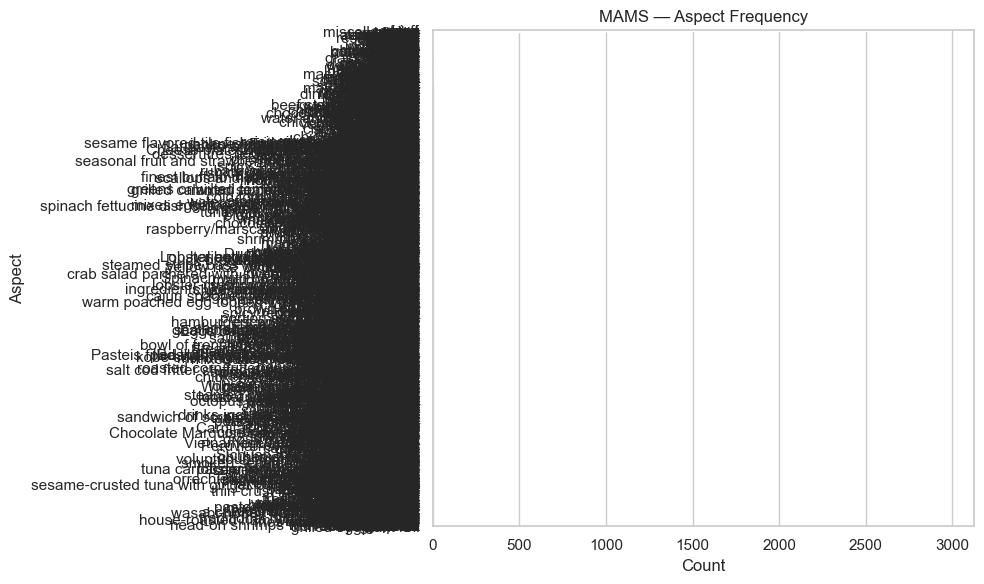


=== Top 20 Aspects ===
aspect
food             2976
staff            1493
service          1007
miscellaneous     954
menu              889
place             818
price             428
waiter            403
ambience          352
dinner            309
bar               300
waitress          236
drinks            213
table             162
meal              143
drink             113
dessert           112
lunch             112
wait              110
appetizers        104
Name: count, dtype: int64

=== Aspect × Polarity Crosstab (first 15 rows) ===
polarity             negative  neutral  positive
aspect                                          
'side' dishes               0        0         1
7A                          0        1         0
APPETIZER                   0        0         1
Ambiance                    0        0         1
American                    0        0         1
American fare               0        0         1
American platters           0        0         1
Appetizers

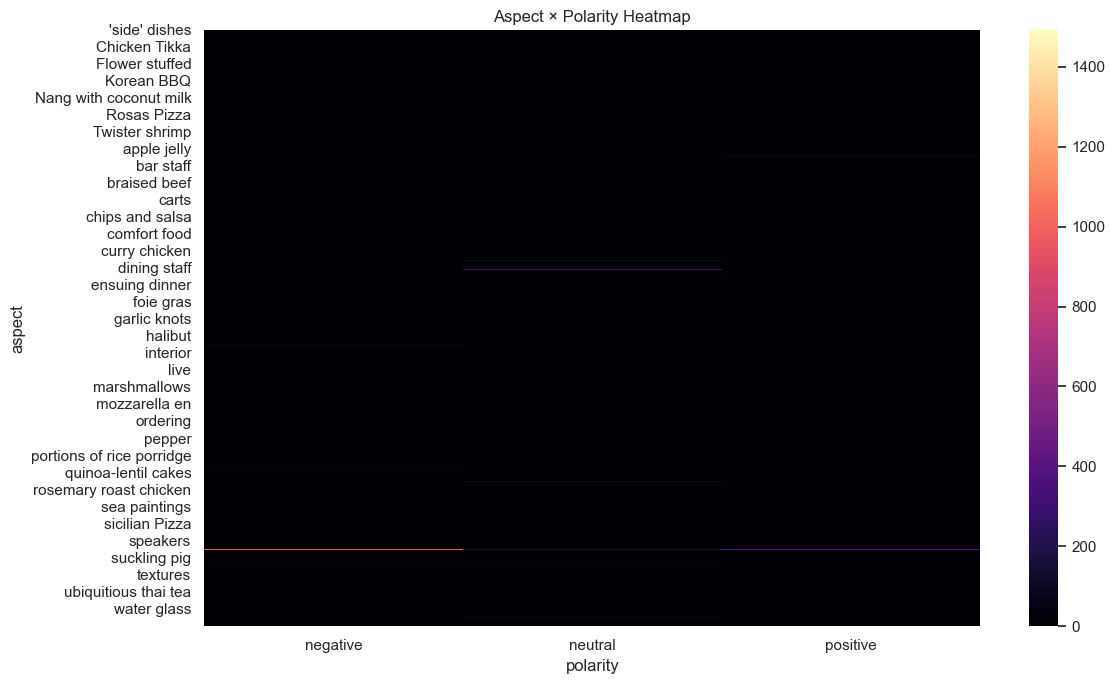


=========== SUMMARY ===========
Total expanded rows: 18276
Unique aspects: 2587

Polarity (%)
polarity
neutral     44.42
positive    29.05
negative    26.53
Name: proportion, dtype: float64

Most common aspect: food

DONE — Dataset fully profiled.


In [4]:
# ============================================================
# 1. Load dataset
# ============================================================

from datasets import load_dataset
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

ds = load_dataset("NEUDM/mams")
train = ds["train"].to_pandas()

print("Columns:", train.columns.tolist())
print("Train shape:", train.shape)


# ============================================================
# 2. Clean sentence column ("['text']" → "text")
# ============================================================

def clean_list_string(x):
    """Convert string like "['text']" → 'text'."""
    try:
        parsed = ast.literal_eval(x)
        if isinstance(parsed, list) and len(parsed) > 0:
            return parsed[0]
    except:
        return x
    return x

train["sentence"] = train["input"].apply(clean_list_string)


# ============================================================
# 3. Extract polarity labels from output list
#    output = [['aspect', 'polarity'], ...]
# ============================================================

def extract_polarities(x):
    try:
        parsed = ast.literal_eval(x)
        if isinstance(parsed, list):
            return [p[1] for p in parsed]
    except:
        return []
    return []


def extract_aspects(x):
    try:
        parsed = ast.literal_eval(x)
        if isinstance(parsed, list):
            return [p[0] for p in parsed]
    except:
        return []
    return []


train["polarity_list"] = train["output"].apply(extract_polarities)
train["aspect_list"]   = train["output"].apply(extract_aspects)


# ============================================================
# 4. Expand polarity list into 1-row-per-aspect
# ============================================================

rows = []

for idx, row in train.iterrows():
    sentence = row["sentence"]
    aspects = row["aspect_list"]
    pols = row["polarity_list"]

    for a, p in zip(aspects, pols):
        rows.append({
            "sentence": sentence,
            "aspect": a,
            "polarity": p
        })

expanded = pd.DataFrame(rows)

print("Expanded shape:", expanded.shape)
print(expanded.head())


# ============================================================
# 5. Plot polarity distribution
# ============================================================

plt.figure(figsize=(6,4))
sns.countplot(x=expanded["polarity"], palette="viridis")
plt.title("MAMS — Polarity Distribution (Expanded)")
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("\n=== Polarity Counts ===")
print(expanded["polarity"].value_counts())
print("\n=== Polarity Percent (%) ===")
print((expanded["polarity"].value_counts(normalize=True)*100).round(2))


# ============================================================
# 6. Aspect frequency
# ============================================================

plt.figure(figsize=(10,6))
sns.countplot(
    y=expanded["aspect"],
    order=expanded["aspect"].value_counts().index,
    palette="Blues_r"
)
plt.title("MAMS — Aspect Frequency")
plt.xlabel("Count")
plt.ylabel("Aspect")
plt.tight_layout()
plt.show()

print("\n=== Top 20 Aspects ===")
print(expanded["aspect"].value_counts().head(20))


# ============================================================
# 7. Aspect × Polarity Crosstab
# ============================================================

crosstab = pd.crosstab(expanded["aspect"], expanded["polarity"])
print("\n=== Aspect × Polarity Crosstab (first 15 rows) ===")
print(crosstab.head(15))

plt.figure(figsize=(12,7))
sns.heatmap(crosstab, cmap="magma", cbar=True)
plt.title("Aspect × Polarity Heatmap")
plt.tight_layout()
plt.show()


# ============================================================
# 8. Summary
# ============================================================

print("\n=========== SUMMARY ===========")
print("Total expanded rows:", len(expanded))
print("Unique aspects:", expanded["aspect"].nunique())

print("\nPolarity (%)")
print((expanded["polarity"].value_counts(normalize=True)*100).round(2))

print("\nMost common aspect:", expanded["aspect"].value_counts().idxmax())

print("\nDONE — Dataset fully profiled.")